In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

import sys
ROOT = "../../"
sys.path.append(ROOT) # Add root directory to path

from src.utils.perturbations import *

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [2]:
# Step 1: Load the CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
num_classes = 10

Files already downloaded and verified
Files already downloaded and verified


In [3]:
x_train = trainset.data / 255.0  # Scale pixel values to [0, 1]
y_train = np.array(trainset.targets)
x_test = testset.data / 255.0  # Scale pixel values to [0, 1]
y_test = np.array(testset.targets)

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

y_train = np.eye(num_classes)[y_train].astype(np.float32)
y_test = np.eye(num_classes)[y_test].astype(np.float32)

min_pixel_value = 0.0
max_pixel_value = 1.0

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train = torch.from_numpy(x_train).to(device)
y_train = torch.from_numpy(y_train).to(device)

x_test = torch.from_numpy(x_test).to(device)
y_test = torch.from_numpy(y_test).to(device)

In [5]:
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = SimpleDataset(x_train, y_train)
test_dataset = SimpleDataset(x_test, y_test)

In [27]:
test_history = []

def display_test_history(test_history, eps_values):
    for i in range(len(test_history)):
        test = test_history[i]
        num_p = len(test['perturbations'])
        training_time = test['training_time']

        baseline = test['baseline_test_accuracy']
        adv_str = ""
        for eps in eps_values:
            adv_acc = test[f'adversarial_accuracy_eps={eps}']
            adv_str += f"[eps={eps}:{adv_acc*100:.2f}%],"
        adv_str = adv_str[:-1]
        print(f"Test {i}: # Perturbations ({num_p}), Time ({training_time:.2f}s), Baseline ({baseline*100:.2f}%), Adversarial ({adv_str})")

In [7]:
class Perturbations():
    def __init__(self, perturbations, include_original=False, shuffle=True):
        self.perturbations = perturbations
        self.multiplicity = len(perturbations) + int(include_original)
        self.shuffle = shuffle
        self.include_original = include_original
    
    def __getitem__(self, idx):
        return self.perturbations[idx]
    
    def __len__(self):
        return len(self.perturbations)

    def get_multiplicity(self):
        if len(self.perturbations) == 0 and not self.include_original:
            return 1
        return self.multiplicity
        
    def get_include_original(self):
        return len(self.perturbations) == 0 or self.include_original
    
    def get_shuffle(self):
        return self.shuffle

    def add_perturbation(self, perturbation):
        if type(perturbation) == list:
            self.perturbations.append(perturbation[0])
        else:
            self.perturbations.append(perturbation)
        self.multiplicity = len(self.perturbations) + int(self.include_original)

In [8]:
class REPClassifier(nn.Module):
    def __init__(self, perturbations):
        super(REPClassifier, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.perturbations = perturbations
        self.multiplicity = perturbations.get_multiplicity()
        self.include_original = perturbations.get_include_original()
        self.shuffle = perturbations.get_shuffle()

        self.conv1 = nn.Conv2d(3*self.multiplicity, 96, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(96, 96, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(96, 80, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(80, 64, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(64, 96, kernel_size=5, padding=2)
        self.global_pool = nn.AdaptiveMaxPool2d((2, 2))

        self.fc1 = nn.Linear(96*2*2, 256)
        self.nonlinearity1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
        self.to(self.device)

    def forward(self, x):
        x = x.to(self.device) # shape = (Batch, Color Channels, Height, Width)
        if x.dim() == 3:
            x = x.unsqueeze(0)
        B = x.size(0)

        # Apply perturbations
        layers = []
        if self.include_original:
            layers.append(x)
        for perturbation in self.perturbations:
            layers.append(perturbation(x))
        if self.shuffle:
            permutation = torch.randperm(len(layers))
            layers = [layers[i] for i in permutation]
        x = torch.cat(layers, dim=1) # stack along color channel dimension -> shape = (Batch, Color Channels x Multiplicity, H, W)

        x = self.conv1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.global_pool(x)
        x = x.view(B, -1)

        x = self.fc1(x)
        x = self.nonlinearity1(x)
        x = self.fc2(x)
        return x

In [9]:
from tqdm.auto import tqdm

def train_REPClassifier(model, dataset, optimizer, criterion, batch_size, epochs, test_dataset=None, verbose=True):
    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=0)
    test_accuracy_history = []
    test_loss_history = []
    for _ in tqdm(range(epochs), disable=not verbose, desc="Epochs"):
        for x_batch, y_batch in dataloader:            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Perform prediction
            model_outputs = model(x_batch)

            y_batch = y_batch.squeeze(1)
            predictions = model_outputs.squeeze(1)
            
            loss = criterion(predictions, y_batch)

            # Do training
            loss.backward()

            optimizer.step()
        if test_dataset:
            with torch.no_grad():
                x_test = test_dataset.x
                y_test = test_dataset.y
                test_outputs = model(x_test)
                test_predictions = test_outputs.squeeze(1)
                y_test = y_test.squeeze(1)

                test_loss = criterion(test_predictions, y_test)
                test_loss_history.append(test_loss.item().cpu().numpy())

                test_accuracy = torch.sum(torch.argmax(test_outputs, axis=1) == torch.argmax(y_test, axis=1)) / len(x_test)
                test_accuracy_history.append(test_accuracy.cpu())
    return test_accuracy_history, test_loss_history

# Test Single Model

In [10]:
# perturbation_descriptions = [["Gaussian", 0.05], ["Laplacian", 0.05]]
# perturbation_descriptions = [["Gaussian", 0.05]]
perturbation_descriptions = []
perturbation_functions = create_perturbations(perturbation_descriptions)

perturbations = Perturbations(perturbation_functions)

In [11]:
model = REPClassifier(perturbations)

In [15]:
load_trained_model = True
model_name = "model1.pt"
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
batch_size = 64
epochs = 20

if load_trained_model:
    state_dict = torch.load(ROOT + "src/models/" + model_name)
    model.load_state_dict(state_dict)
else:
    accuracy, loss = train_REPClassifier(model, train_dataset, optimizer, criterion, batch_size, epochs)
    torch.save(model.state_dict(), ROOT + "src/models/" + model_name)

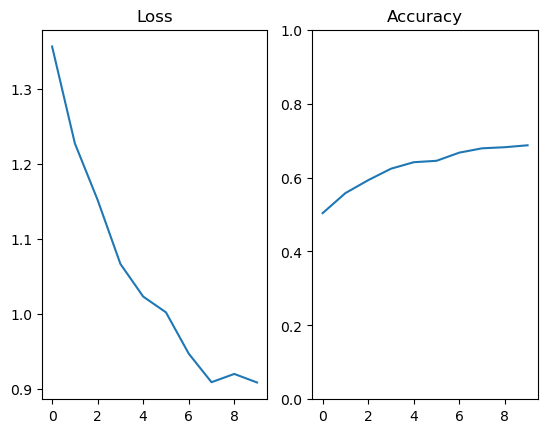

In [37]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(loss, label="Loss")
axs[0].set_title("Loss")
axs[1].plot(accuracy, label="Accuracy")
axs[1].set_ylim(0, 1)
axs[1].set_title("Accuracy")
plt.show()

In [13]:
with torch.no_grad():
    train_accuracy = torch.sum(torch.argmax(model(x_train[:1200]), axis=1) == torch.argmax(y_train[:1200], axis=1)) / len(x_train[:1200])
    test_accuracy = torch.sum(torch.argmax(model(x_test), axis=1) == torch.argmax(y_test, axis=1)) / len(x_test)
    print(f"Train Acc: {train_accuracy}, Test Acc: {test_accuracy}")

Train Acc: 0.8758333325386047, Test Acc: 0.7216999530792236


In [17]:
classifier = PyTorchClassifier(
        model=model,
        clip_values=(min_pixel_value, max_pixel_value),
        loss=criterion,
        optimizer=optimizer,
        input_shape=(3, 28, 28),
        nb_classes=num_classes,
    )

x_test_numpy = x_test.cpu().numpy()
y_test_numpy = y_test.cpu().numpy()
with torch.no_grad():
    # Step 5: Evaluate the ART classifier on benign test examples
    predictions = classifier.predict(x_test_numpy)
    baseline_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test)
    print("Accuracy on benign test examples: {}%".format(baseline_accuracy * 100))

# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.025)
x_test_adv1 = attack.generate(x=x_test_numpy)
with torch.no_grad():
    predictions = classifier.predict(x_test_adv1)
    adversarial_accuracy1 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.025): {}%".format(adversarial_accuracy1 * 100))

attack = FastGradientMethod(estimator=classifier, eps=0.05)
x_test_adv2 = attack.generate(x=x_test_numpy)
with torch.no_grad():
    predictions = classifier.predict(x_test_adv2)
    adversarial_accuracy2 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.05): {}%".format(adversarial_accuracy2 * 100))

attack = FastGradientMethod(estimator=classifier, eps=0.075)
x_test_adv3 = attack.generate(x=x_test_numpy)
with torch.no_grad():
    predictions = classifier.predict(x_test_adv3)
    adversarial_accuracy3 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.075): {}%".format(adversarial_accuracy3 * 100))

attack = FastGradientMethod(estimator=classifier, eps=0.1)
x_test_adv4 = attack.generate(x=x_test_numpy)
with torch.no_grad():
    predictions = classifier.predict(x_test_adv4)
    adversarial_accuracy4 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.1): {}%".format(adversarial_accuracy4 * 100))

Accuracy on benign test examples: 72.17%
Accuracy on adversarial test examples (epsilon = 0.025): 18.83%
Accuracy on adversarial test examples (epsilon = 0.05): 13.77%
Accuracy on adversarial test examples (epsilon = 0.075): 11.99%
Accuracy on adversarial test examples (epsilon = 0.1): 10.59%


# Test Multiple Models

In [16]:
perturbation_descriptions = [
    [],
    [["Identity"], ["Identity"]],
    [["Identity"], ["Identity"], ["Identity"]],
    [["RotationFlip", 0.3]],
    [["SaltPepper", 0.05]],
    [[["RotationFlip", 0.3], ["SaltPepper", 0.05]]],
    [["RotationFlip", 0.3], ["SaltPepper", 0.05]],
    [["Lp-norm", 0.05, 1], ["Lp-norm", 0.05, 2], ["Lp-norm", 0.05, 3], ["Lp-norm", 0.05, 4], ["Lp-norm", 0.05, float('inf')]],
    [["Lp-norm", 0.05, 11], ["Lp-norm", 0.05, 12], ["Lp-norm", 0.05, 13], ["Lp-norm", 0.05, 14], ["Lp-norm", 0.05, float('inf')]],
    [["Lp-norm", 0.1, 1], ["Lp-norm", 0.1, 2], ["Lp-norm", 0.1, 3], ["Lp-norm", 0.1, 4], ["Lp-norm", 0.1, float('inf')]],
    [["Lp-norm", 0.1, 11], ["Lp-norm", 0.1, 12], ["Lp-norm", 0.1, 13], ["Lp-norm", 0.1, 14], ["Lp-norm", 0.1, float('inf')]],
    [[["Lp-norm", 0.1, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.1, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.1, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.1, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.1, float('inf')],["RotationFlip", 0.3]]],
    [[["Lp-norm", 0.1, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.1, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.1, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.1, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.1, float('inf')],["RotationFlip", 0.3]], [["Lp-norm", 0.1, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.1, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.1, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.1, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.1, float('inf')],["RotationFlip", 0.3]]],
    [[["Lp-norm", 0.1, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.1, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.1, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.1, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.1, float('inf')],["SaltPepper", 0.05]]],
    [[["Lp-norm", 0.1, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.1, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.1, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.1, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.1, float('inf')],["SaltPepper", 0.05]], [["Lp-norm", 0.1, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.1, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.1, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.1, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.1, float('inf')],["SaltPepper", 0.05]]],
    [[["Lp-norm", 0.1, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.1, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.1, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.1, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.1, float('inf')],["RotationFlip", 0.3]], [["Lp-norm", 0.1, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.1, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.1, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.1, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.1, float('inf')],["SaltPepper", 0.05]]],
    ]

all_perturbations = [Perturbations(create_perturbations(perturbation_description)) for perturbation_description in perturbation_descriptions]

In [30]:
test_folder = "FRESH_CNN_CIFAR_10_1"
epochs = 20
batch_size = 64
criterion = nn.CrossEntropyLoss()

eps_values = [0.025, 0.5, 0.75, 0.1]
x_train_numpy = x_train.cpu().numpy()
y_train_numpy = y_train.cpu().numpy()
x_test_numpy = x_test.cpu().numpy()
y_test_numpy = y_test.cpu().numpy()

test_history = []

for i in range(len(all_perturbations)):
    perturbations = all_perturbations[i]
    model_name = f"model{i}.pt"
    
    model = REPClassifier(perturbations)
    lr = 0.0001
    weight_decay = 0.0001
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    print(f"Training {model_name} with perturbations:")
    print(perturbation_descriptions[i])

    # Train model
    training_start = time.time()
    train_REPClassifier(model, train_dataset, optimizer, criterion, batch_size, epochs)
    training_time = time.time() - training_start
    torch.save(model.state_dict(), ROOT + "src/models/" + test_folder + "/" + model_name)
    print(f"Training Complete After: {training_time}s")


    # Insert the model into the pytorch classifier from ART to allow for adversarial attack generation
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(min_pixel_value, max_pixel_value),
        loss=criterion,
        optimizer=optimizer,
        input_shape=(3, 28, 28),
        nb_classes=num_classes,
    )

    # Evaluate on benign examples
    with torch.no_grad():
        train_predictions = classifier.predict(x_train_numpy)
        baseline_train_accuracy = np.sum(np.argmax(train_predictions, axis=1) == np.argmax(y_train_numpy, axis=1)) / len(y_train_numpy)
        print("Accuracy on benign train examples: {}%".format(baseline_train_accuracy * 100))
        
        test_predictions = classifier.predict(x_test_numpy)
        baseline_test_accuracy = np.sum(np.argmax(test_predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test_numpy)
        print("Accuracy on benign test examples: {}%".format(baseline_test_accuracy * 100))
    
    test_history.append({
        'perturbations': perturbation_descriptions[i],
        'include_original': perturbations.get_include_original(),
        'shuffle': perturbations.get_shuffle(),
        'loss': criterion,
        'lr': lr,
        'weight_decay': weight_decay,
        'batch_size': batch_size,
        'epochs': epochs,
        'training_time': training_time,
        'baseline_train_accuracy': baseline_train_accuracy,
        'baseline_test_accuracy': baseline_test_accuracy,
        })

    # Evaluate against FGSM
    for eps in eps_values:
        attack = FastGradientMethod(estimator=classifier, eps=eps)
        x_test_adv = attack.generate(x=x_test_numpy)
        with torch.no_grad():
            predictions = classifier.predict(x_test_adv)
            adversarial_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test_numpy)
            print(f"Accuracy on adversarial test examples (epsilon = {eps}): {adversarial_accuracy * 100:.2f}%")
        test_history[i][f"adversarial_accuracy_eps={eps}"] = adversarial_accuracy
display_test_history(test_history, eps_values)

Training model0.pt with perturbations:
[]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 59.230708360672s
Accuracy on benign train examples: 87.20599999999999%
Accuracy on benign test examples: 73.04%
Accuracy on adversarial test examples (epsilon = 0.025): 17.93%
Accuracy on adversarial test examples (epsilon = 0.5): 8.42%
Accuracy on adversarial test examples (epsilon = 0.75): 9.08%
Accuracy on adversarial test examples (epsilon = 0.1): 10.81%
Training model1.pt with perturbations:
[['Identity'], ['Identity']]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 59.95062565803528s
Accuracy on benign train examples: 87.488%
Accuracy on benign test examples: 73.04%
Accuracy on adversarial test examples (epsilon = 0.025): 17.64%
Accuracy on adversarial test examples (epsilon = 0.5): 10.17%
Accuracy on adversarial test examples (epsilon = 0.75): 10.50%
Accuracy on adversarial test examples (epsilon = 0.1): 11.27%
Training model2.pt with perturbations:
[['Identity'], ['Identity'], ['Identity']]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 67.46201491355896s
Accuracy on benign train examples: 88.454%
Accuracy on benign test examples: 72.92999999999999%
Accuracy on adversarial test examples (epsilon = 0.025): 16.90%
Accuracy on adversarial test examples (epsilon = 0.5): 9.19%
Accuracy on adversarial test examples (epsilon = 0.75): 9.90%
Accuracy on adversarial test examples (epsilon = 0.1): 10.93%
Training model3.pt with perturbations:
[['RotationFlip', 0.3]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 70.21249675750732s
Accuracy on benign train examples: 70.238%
Accuracy on benign test examples: 65.86999999999999%
Accuracy on adversarial test examples (epsilon = 0.025): 38.79%
Accuracy on adversarial test examples (epsilon = 0.5): 9.74%
Accuracy on adversarial test examples (epsilon = 0.75): 10.45%
Accuracy on adversarial test examples (epsilon = 0.1): 14.78%
Training model4.pt with perturbations:
[['SaltPepper', 0.05]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 72.56822204589844s
Accuracy on benign train examples: 80.262%
Accuracy on benign test examples: 67.96%
Accuracy on adversarial test examples (epsilon = 0.025): 39.15%
Accuracy on adversarial test examples (epsilon = 0.5): 8.35%
Accuracy on adversarial test examples (epsilon = 0.75): 8.82%
Accuracy on adversarial test examples (epsilon = 0.1): 14.75%
Training model5.pt with perturbations:
[[['RotationFlip', 0.3], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 82.84572124481201s
Accuracy on benign train examples: 64.614%
Accuracy on benign test examples: 61.419999999999995%
Accuracy on adversarial test examples (epsilon = 0.025): 47.02%
Accuracy on adversarial test examples (epsilon = 0.5): 11.10%
Accuracy on adversarial test examples (epsilon = 0.75): 11.31%
Accuracy on adversarial test examples (epsilon = 0.1): 21.74%
Training model6.pt with perturbations:
[['RotationFlip', 0.3], ['SaltPepper', 0.05]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 92.04742431640625s
Accuracy on benign train examples: 70.182%
Accuracy on benign test examples: 65.68%
Accuracy on adversarial test examples (epsilon = 0.025): 42.44%
Accuracy on adversarial test examples (epsilon = 0.5): 9.55%
Accuracy on adversarial test examples (epsilon = 0.75): 10.19%
Accuracy on adversarial test examples (epsilon = 0.1): 17.71%
Training model7.pt with perturbations:
[['Lp-norm', 0.05, 1], ['Lp-norm', 0.05, 2], ['Lp-norm', 0.05, 3], ['Lp-norm', 0.05, 4], ['Lp-norm', 0.05, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 79.40236783027649s
Accuracy on benign train examples: 88.29599999999999%
Accuracy on benign test examples: 73.94%
Accuracy on adversarial test examples (epsilon = 0.025): 17.39%
Accuracy on adversarial test examples (epsilon = 0.5): 10.04%
Accuracy on adversarial test examples (epsilon = 0.75): 11.36%
Accuracy on adversarial test examples (epsilon = 0.1): 11.55%
Training model8.pt with perturbations:
[['Lp-norm', 0.05, 11], ['Lp-norm', 0.05, 12], ['Lp-norm', 0.05, 13], ['Lp-norm', 0.05, 14], ['Lp-norm', 0.05, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 76.59738492965698s
Accuracy on benign train examples: 87.712%
Accuracy on benign test examples: 72.56%
Accuracy on adversarial test examples (epsilon = 0.025): 18.50%
Accuracy on adversarial test examples (epsilon = 0.5): 8.33%
Accuracy on adversarial test examples (epsilon = 0.75): 9.04%
Accuracy on adversarial test examples (epsilon = 0.1): 12.01%
Training model9.pt with perturbations:
[['Lp-norm', 0.1, 1], ['Lp-norm', 0.1, 2], ['Lp-norm', 0.1, 3], ['Lp-norm', 0.1, 4], ['Lp-norm', 0.1, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 76.23405981063843s
Accuracy on benign train examples: 89.896%
Accuracy on benign test examples: 73.42%
Accuracy on adversarial test examples (epsilon = 0.025): 17.65%
Accuracy on adversarial test examples (epsilon = 0.5): 10.66%
Accuracy on adversarial test examples (epsilon = 0.75): 11.66%
Accuracy on adversarial test examples (epsilon = 0.1): 11.73%
Training model10.pt with perturbations:
[['Lp-norm', 0.1, 11], ['Lp-norm', 0.1, 12], ['Lp-norm', 0.1, 13], ['Lp-norm', 0.1, 14], ['Lp-norm', 0.1, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 77.56748700141907s
Accuracy on benign train examples: 86.92800000000001%
Accuracy on benign test examples: 72.0%
Accuracy on adversarial test examples (epsilon = 0.025): 18.61%
Accuracy on adversarial test examples (epsilon = 0.5): 9.30%
Accuracy on adversarial test examples (epsilon = 0.75): 10.16%
Accuracy on adversarial test examples (epsilon = 0.1): 11.65%
Training model11.pt with perturbations:
[[['Lp-norm', 0.1, 1], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, 2], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, 3], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, 4], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, inf], ['RotationFlip', 0.3]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 103.27079343795776s
Accuracy on benign train examples: 71.056%
Accuracy on benign test examples: 65.61%
Accuracy on adversarial test examples (epsilon = 0.025): 35.96%
Accuracy on adversarial test examples (epsilon = 0.5): 10.36%
Accuracy on adversarial test examples (epsilon = 0.75): 10.10%
Accuracy on adversarial test examples (epsilon = 0.1): 15.11%
Training model12.pt with perturbations:
[[['Lp-norm', 0.1, 1], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, 2], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, 3], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, 4], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, inf], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, 1], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, 2], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, 3], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, 4], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, inf], ['RotationFlip', 0.3]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 143.59604334831238s
Accuracy on benign train examples: 73.248%
Accuracy on benign test examples: 66.97%
Accuracy on adversarial test examples (epsilon = 0.025): 27.75%
Accuracy on adversarial test examples (epsilon = 0.5): 10.46%
Accuracy on adversarial test examples (epsilon = 0.75): 10.63%
Accuracy on adversarial test examples (epsilon = 0.1): 12.73%
Training model13.pt with perturbations:
[[['Lp-norm', 0.1, 1], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, 2], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, 3], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, 4], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, inf], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 108.75796818733215s
Accuracy on benign train examples: 84.454%
Accuracy on benign test examples: 69.77%
Accuracy on adversarial test examples (epsilon = 0.025): 25.81%
Accuracy on adversarial test examples (epsilon = 0.5): 8.68%
Accuracy on adversarial test examples (epsilon = 0.75): 9.78%
Accuracy on adversarial test examples (epsilon = 0.1): 13.16%
Training model14.pt with perturbations:
[[['Lp-norm', 0.1, 1], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, 2], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, 3], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, 4], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, inf], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, 1], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, 2], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, 3], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, 4], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, inf], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 161.33806347846985s
Accuracy on benign train examples: 88.196%
Accuracy on benign test examples: 69.84%
Accuracy on adversarial test examples (epsilon = 0.025): 23.49%
Accuracy on adversarial test examples (epsilon = 0.5): 8.63%
Accuracy on adversarial test examples (epsilon = 0.75): 9.45%
Accuracy on adversarial test examples (epsilon = 0.1): 14.00%
Training model15.pt with perturbations:
[[['Lp-norm', 0.1, 1], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, 2], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, 3], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, 4], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, inf], ['RotationFlip', 0.3]], [['Lp-norm', 0.1, 1], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, 2], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, 3], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, 4], ['SaltPepper', 0.05]], [['Lp-norm', 0.1, inf], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 154.39897632598877s
Accuracy on benign train examples: 82.572%
Accuracy on benign test examples: 69.19999999999999%
Accuracy on adversarial test examples (epsilon = 0.025): 26.51%
Accuracy on adversarial test examples (epsilon = 0.5): 9.97%
Accuracy on adversarial test examples (epsilon = 0.75): 10.19%
Accuracy on adversarial test examples (epsilon = 0.1): 13.29%
Test 0: # Perturbations (0), Time (59.23s), Baseline (73.04%), Adversarial ([eps=0.025:17.93%],[eps=0.5:8.42%],[eps=0.75:9.08%],[eps=0.1:10.81%])
Test 1: # Perturbations (2), Time (59.95s), Baseline (73.04%), Adversarial ([eps=0.025:17.64%],[eps=0.5:10.17%],[eps=0.75:10.50%],[eps=0.1:11.27%])
Test 2: # Perturbations (3), Time (67.46s), Baseline (72.93%), Adversarial ([eps=0.025:16.90%],[eps=0.5:9.19%],[eps=0.75:9.90%],[eps=0.1:10.93%])
Test 3: # Perturbations (1), Time (70.21s), Baseline (65.87%), Adversarial ([eps=0.025:38.79%],[eps=0.5:9.74%],[eps=0.75:10.45%],[eps=0.1:14.78%])
Test 4: # Perturbation

In [31]:
perturbation_descriptions = [
    [["Lp-norm", 0.25, 1], ["Lp-norm", 0.25, 2], ["Lp-norm", 0.25, 3], ["Lp-norm", 0.25, 4], ["Lp-norm", 0.25, float('inf')]],
    [["Lp-norm", 0.25, 11], ["Lp-norm", 0.25, 12], ["Lp-norm", 0.25, 13], ["Lp-norm", 0.25, 14], ["Lp-norm", 0.25, float('inf')]],
    [["Lp-norm", 0.5, 1], ["Lp-norm", 0.5, 2], ["Lp-norm", 0.5, 3], ["Lp-norm", 0.5, 4], ["Lp-norm", 0.5, float('inf')]],
    [["Lp-norm", 0.5, 11], ["Lp-norm", 0.5, 12], ["Lp-norm", 0.5, 13], ["Lp-norm", 0.5, 14], ["Lp-norm", 0.5, float('inf')]],
    [[["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]]],
    [[["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]]],
    [[["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]]],
    [[["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]]],
    [[["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], ["Lp-norm", 0.25, 1], ["Lp-norm", 0.25, 2], ["Lp-norm", 0.25, 3], ["Lp-norm", 0.25, 4], ["Lp-norm", 0.25, float('inf')]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], ["Lp-norm", 0.25, 11], ["Lp-norm", 0.25, 12], ["Lp-norm", 0.25, 13], ["Lp-norm", 0.25, 14], ["Lp-norm", 0.25, float('inf')]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], ["Lp-norm", 0.5, 1], ["Lp-norm", 0.5, 2], ["Lp-norm", 0.5, 3], ["Lp-norm", 0.5, 4], ["Lp-norm", 0.5, float('inf')]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], ["Lp-norm", 0.5, 11], ["Lp-norm", 0.5, 12], ["Lp-norm", 0.5, 13], ["Lp-norm", 0.5, 14], ["Lp-norm", 0.5, float('inf')]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]]],
    [[["Laplacian", 0.05],["RotationFlip", 0.3]], ["Lp-norm", 0.25, 1], ["Lp-norm", 0.25, 2], ["Lp-norm", 0.25, 3], ["Lp-norm", 0.25, 4], ["Lp-norm", 0.25, float('inf')]],
    [[["Laplacian", 0.05],["RotationFlip", 0.3]], ["Lp-norm", 0.25, 11], ["Lp-norm", 0.25, 12], ["Lp-norm", 0.25, 13], ["Lp-norm", 0.25, 14], ["Lp-norm", 0.25, float('inf')]],
    [[["Laplacian", 0.05],["RotationFlip", 0.3]], ["Lp-norm", 0.5, 1], ["Lp-norm", 0.5, 2], ["Lp-norm", 0.5, 3], ["Lp-norm", 0.5, 4], ["Lp-norm", 0.5, float('inf')]],
    [[["Laplacian", 0.05],["RotationFlip", 0.3]], ["Lp-norm", 0.5, 11], ["Lp-norm", 0.5, 12], ["Lp-norm", 0.5, 13], ["Lp-norm", 0.5, 14], ["Lp-norm", 0.5, float('inf')]],
    [[["Laplacian", 0.05],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]]],
    [[["Laplacian", 0.05],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]]],
    [[["Laplacian", 0.05],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]]],
    [[["Laplacian", 0.05],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]]],
    [[["Laplacian", 0.05],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], [["Laplacian", 0.05],["RotationFlip", 0.3]], ["Lp-norm", 0.25, 1], ["Lp-norm", 0.25, 2], ["Lp-norm", 0.25, 3], ["Lp-norm", 0.25, 4], ["Lp-norm", 0.25, float('inf')]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], [["Laplacian", 0.05],["RotationFlip", 0.3]], ["Lp-norm", 0.25, 11], ["Lp-norm", 0.25, 12], ["Lp-norm", 0.25, 13], ["Lp-norm", 0.25, 14], ["Lp-norm", 0.25, float('inf')]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], [["Laplacian", 0.05],["RotationFlip", 0.3]], ["Lp-norm", 0.5, 1], ["Lp-norm", 0.5, 2], ["Lp-norm", 0.5, 3], ["Lp-norm", 0.5, 4], ["Lp-norm", 0.5, float('inf')]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], [["Laplacian", 0.05],["RotationFlip", 0.3]], ["Lp-norm", 0.5, 11], ["Lp-norm", 0.5, 12], ["Lp-norm", 0.5, 13], ["Lp-norm", 0.5, 14], ["Lp-norm", 0.5, float('inf')]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], [["Laplacian", 0.05],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], [["Laplacian", 0.05],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], [["Laplacian", 0.05],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], [["Laplacian", 0.05],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]]],
    [[["Gaussian", 0.05],["RotationFlip", 0.3]], [["Laplacian", 0.05],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]], [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]], [["Lp-norm", 0.5, 1],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]], [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]], [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]]],
    ]

all_perturbations = [Perturbations(create_perturbations(perturbation_description)) for perturbation_description in perturbation_descriptions]

In [32]:
test_folder = "FRESH_CNN_CIFAR_10_1"
initial_index = len(test_history)
epochs = 20
batch_size = 64
criterion = nn.CrossEntropyLoss()

eps_values = [0.025, 0.5, 0.75, 0.1]
x_train_numpy = x_train.cpu().numpy()
y_train_numpy = y_train.cpu().numpy()
x_test_numpy = x_test.cpu().numpy()
y_test_numpy = y_test.cpu().numpy()

for i in range(len(all_perturbations)):
    perturbations = all_perturbations[i]
    model_name = f"model{initial_index + i}.pt"
    
    model = REPClassifier(perturbations)
    lr = 0.0001
    weight_decay = 0.0001
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    print(f"Training {model_name} with perturbations:")
    print(perturbation_descriptions[i])

    # Train model
    training_start = time.time()
    train_REPClassifier(model, train_dataset, optimizer, criterion, batch_size, epochs)
    training_time = time.time() - training_start
    torch.save(model.state_dict(), ROOT + "src/models/" + test_folder + "/" + model_name)
    print(f"Training Complete After: {training_time}s")


    # Insert the model into the pytorch classifier from ART to allow for adversarial attack generation
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(min_pixel_value, max_pixel_value),
        loss=criterion,
        optimizer=optimizer,
        input_shape=(3, 28, 28),
        nb_classes=num_classes,
    )

    # Evaluate on benign examples
    with torch.no_grad():
        train_predictions = classifier.predict(x_train_numpy)
        baseline_train_accuracy = np.sum(np.argmax(train_predictions, axis=1) == np.argmax(y_train_numpy, axis=1)) / len(y_train_numpy)
        print("Accuracy on benign train examples: {}%".format(baseline_train_accuracy * 100))
        
        test_predictions = classifier.predict(x_test_numpy)
        baseline_test_accuracy = np.sum(np.argmax(test_predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test_numpy)
        print("Accuracy on benign test examples: {}%".format(baseline_test_accuracy * 100))
    
    test_history.append({
        'perturbations': perturbation_descriptions[i],
        'include_original': perturbations.get_include_original(),
        'shuffle': perturbations.get_shuffle(),
        'loss': criterion,
        'lr': lr,
        'weight_decay': weight_decay,
        'batch_size': batch_size,
        'epochs': epochs,
        'training_time': training_time,
        'baseline_train_accuracy': baseline_train_accuracy,
        'baseline_test_accuracy': baseline_test_accuracy,
        })

    # Evaluate against FGSM
    for eps in eps_values:
        attack = FastGradientMethod(estimator=classifier, eps=eps)
        x_test_adv = attack.generate(x=x_test_numpy)
        with torch.no_grad():
            predictions = classifier.predict(x_test_adv)
            adversarial_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test_numpy)
            print(f"Accuracy on adversarial test examples (epsilon = {eps}): {adversarial_accuracy * 100:.2f}%")
        test_history[initial_index + i][f"adversarial_accuracy_eps={eps}"] = adversarial_accuracy
display_test_history(test_history, eps_values)

Training model16.pt with perturbations:
[['Lp-norm', 0.25, 1], ['Lp-norm', 0.25, 2], ['Lp-norm', 0.25, 3], ['Lp-norm', 0.25, 4], ['Lp-norm', 0.25, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 78.53012752532959s
Accuracy on benign train examples: 88.476%
Accuracy on benign test examples: 73.22%
Accuracy on adversarial test examples (epsilon = 0.025): 18.35%
Accuracy on adversarial test examples (epsilon = 0.5): 10.05%
Accuracy on adversarial test examples (epsilon = 0.75): 11.23%
Accuracy on adversarial test examples (epsilon = 0.1): 11.51%
Training model17.pt with perturbations:
[['Lp-norm', 0.25, 11], ['Lp-norm', 0.25, 12], ['Lp-norm', 0.25, 13], ['Lp-norm', 0.25, 14], ['Lp-norm', 0.25, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 79.03865313529968s
Accuracy on benign train examples: 87.33999999999999%
Accuracy on benign test examples: 72.63%
Accuracy on adversarial test examples (epsilon = 0.025): 20.18%
Accuracy on adversarial test examples (epsilon = 0.5): 11.15%
Accuracy on adversarial test examples (epsilon = 0.75): 11.72%
Accuracy on adversarial test examples (epsilon = 0.1): 12.35%
Training model18.pt with perturbations:
[['Lp-norm', 0.5, 1], ['Lp-norm', 0.5, 2], ['Lp-norm', 0.5, 3], ['Lp-norm', 0.5, 4], ['Lp-norm', 0.5, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 78.64333057403564s
Accuracy on benign train examples: 87.256%
Accuracy on benign test examples: 72.0%
Accuracy on adversarial test examples (epsilon = 0.025): 20.46%
Accuracy on adversarial test examples (epsilon = 0.5): 8.76%
Accuracy on adversarial test examples (epsilon = 0.75): 9.13%
Accuracy on adversarial test examples (epsilon = 0.1): 12.07%
Training model19.pt with perturbations:
[['Lp-norm', 0.5, 11], ['Lp-norm', 0.5, 12], ['Lp-norm', 0.5, 13], ['Lp-norm', 0.5, 14], ['Lp-norm', 0.5, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 78.78538656234741s
Accuracy on benign train examples: 86.22%
Accuracy on benign test examples: 71.16%
Accuracy on adversarial test examples (epsilon = 0.025): 22.53%
Accuracy on adversarial test examples (epsilon = 0.5): 11.23%
Accuracy on adversarial test examples (epsilon = 0.75): 11.06%
Accuracy on adversarial test examples (epsilon = 0.1): 12.04%
Training model20.pt with perturbations:
[[['Lp-norm', 0.5, 1], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 2], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 3], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 4], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, inf], ['RotationFlip', 0.3]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 104.75759744644165s
Accuracy on benign train examples: 69.286%
Accuracy on benign test examples: 63.67%
Accuracy on adversarial test examples (epsilon = 0.025): 36.14%
Accuracy on adversarial test examples (epsilon = 0.5): 8.75%
Accuracy on adversarial test examples (epsilon = 0.75): 8.88%
Accuracy on adversarial test examples (epsilon = 0.1): 14.76%
Training model21.pt with perturbations:
[[['Lp-norm', 0.5, 1], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 2], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 3], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 4], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, inf], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 1], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 2], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 3], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 4], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, inf], ['RotationFlip', 0.3]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 149.04807019233704s
Accuracy on benign train examples: 73.494%
Accuracy on benign test examples: 67.86999999999999%
Accuracy on adversarial test examples (epsilon = 0.025): 29.48%
Accuracy on adversarial test examples (epsilon = 0.5): 10.08%
Accuracy on adversarial test examples (epsilon = 0.75): 10.37%
Accuracy on adversarial test examples (epsilon = 0.1): 13.88%
Training model22.pt with perturbations:
[[['Lp-norm', 0.5, 1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 2], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 3], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 4], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 113.78596663475037s
Accuracy on benign train examples: 84.712%
Accuracy on benign test examples: 70.8%
Accuracy on adversarial test examples (epsilon = 0.025): 26.66%
Accuracy on adversarial test examples (epsilon = 0.5): 10.36%
Accuracy on adversarial test examples (epsilon = 0.75): 10.72%
Accuracy on adversarial test examples (epsilon = 0.1): 12.44%
Training model23.pt with perturbations:
[[['Lp-norm', 0.5, 1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 2], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 3], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 4], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 2], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 3], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 4], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 168.45124340057373s
Accuracy on benign train examples: 86.646%
Accuracy on benign test examples: 69.94%
Accuracy on adversarial test examples (epsilon = 0.025): 22.55%
Accuracy on adversarial test examples (epsilon = 0.5): 10.27%
Accuracy on adversarial test examples (epsilon = 0.75): 11.39%
Accuracy on adversarial test examples (epsilon = 0.1): 12.99%
Training model24.pt with perturbations:
[[['Lp-norm', 0.5, 1], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 2], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 3], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 4], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, inf], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 2], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 3], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 4], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 159.4949939250946s
Accuracy on benign train examples: 82.126%
Accuracy on benign test examples: 69.84%
Accuracy on adversarial test examples (epsilon = 0.025): 27.93%
Accuracy on adversarial test examples (epsilon = 0.5): 10.49%
Accuracy on adversarial test examples (epsilon = 0.75): 11.23%
Accuracy on adversarial test examples (epsilon = 0.1): 13.42%
Training model25.pt with perturbations:
[[['Gaussian', 0.05], ['RotationFlip', 0.3]], ['Lp-norm', 0.25, 1], ['Lp-norm', 0.25, 2], ['Lp-norm', 0.25, 3], ['Lp-norm', 0.25, 4], ['Lp-norm', 0.25, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 96.6752758026123s
Accuracy on benign train examples: 84.246%
Accuracy on benign test examples: 71.71%
Accuracy on adversarial test examples (epsilon = 0.025): 22.06%
Accuracy on adversarial test examples (epsilon = 0.5): 10.42%
Accuracy on adversarial test examples (epsilon = 0.75): 10.70%
Accuracy on adversarial test examples (epsilon = 0.1): 11.58%
Training model26.pt with perturbations:
[[['Gaussian', 0.05], ['RotationFlip', 0.3]], ['Lp-norm', 0.25, 11], ['Lp-norm', 0.25, 12], ['Lp-norm', 0.25, 13], ['Lp-norm', 0.25, 14], ['Lp-norm', 0.25, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 96.95855927467346s
Accuracy on benign train examples: 84.53399999999999%
Accuracy on benign test examples: 71.34%
Accuracy on adversarial test examples (epsilon = 0.025): 23.02%
Accuracy on adversarial test examples (epsilon = 0.5): 12.01%
Accuracy on adversarial test examples (epsilon = 0.75): 13.04%
Accuracy on adversarial test examples (epsilon = 0.1): 12.93%
Training model27.pt with perturbations:
[[['Gaussian', 0.05], ['RotationFlip', 0.3]], ['Lp-norm', 0.5, 1], ['Lp-norm', 0.5, 2], ['Lp-norm', 0.5, 3], ['Lp-norm', 0.5, 4], ['Lp-norm', 0.5, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 97.15046906471252s
Accuracy on benign train examples: 85.56%
Accuracy on benign test examples: 71.73%
Accuracy on adversarial test examples (epsilon = 0.025): 23.38%
Accuracy on adversarial test examples (epsilon = 0.5): 10.39%
Accuracy on adversarial test examples (epsilon = 0.75): 10.38%
Accuracy on adversarial test examples (epsilon = 0.1): 13.31%
Training model28.pt with perturbations:
[[['Gaussian', 0.05], ['RotationFlip', 0.3]], ['Lp-norm', 0.5, 11], ['Lp-norm', 0.5, 12], ['Lp-norm', 0.5, 13], ['Lp-norm', 0.5, 14], ['Lp-norm', 0.5, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 97.01641082763672s
Accuracy on benign train examples: 84.42%
Accuracy on benign test examples: 71.1%
Accuracy on adversarial test examples (epsilon = 0.025): 24.36%
Accuracy on adversarial test examples (epsilon = 0.5): 11.14%
Accuracy on adversarial test examples (epsilon = 0.75): 12.18%
Accuracy on adversarial test examples (epsilon = 0.1): 11.77%
Training model29.pt with perturbations:
[[['Gaussian', 0.05], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 1], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 2], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 3], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 4], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, inf], ['RotationFlip', 0.3]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 112.91150450706482s
Accuracy on benign train examples: 69.69%
Accuracy on benign test examples: 64.89%
Accuracy on adversarial test examples (epsilon = 0.025): 33.42%
Accuracy on adversarial test examples (epsilon = 0.5): 11.00%
Accuracy on adversarial test examples (epsilon = 0.75): 11.01%
Accuracy on adversarial test examples (epsilon = 0.1): 15.58%
Training model30.pt with perturbations:
[[['Gaussian', 0.05], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 1], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 2], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 3], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 4], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, inf], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 1], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 2], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 3], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 4], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, inf], ['RotationFlip', 0.3]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 162.02156972885132s
Accuracy on benign train examples: 73.27%
Accuracy on benign test examples: 66.03999999999999%
Accuracy on adversarial test examples (epsilon = 0.025): 27.47%
Accuracy on adversarial test examples (epsilon = 0.5): 8.06%
Accuracy on adversarial test examples (epsilon = 0.75): 8.26%
Accuracy on adversarial test examples (epsilon = 0.1): 12.54%
Training model31.pt with perturbations:
[[['Gaussian', 0.05], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 2], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 3], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 4], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 122.91661334037781s
Accuracy on benign train examples: 82.39800000000001%
Accuracy on benign test examples: 69.71000000000001%
Accuracy on adversarial test examples (epsilon = 0.025): 27.36%
Accuracy on adversarial test examples (epsilon = 0.5): 11.65%
Accuracy on adversarial test examples (epsilon = 0.75): 12.43%
Accuracy on adversarial test examples (epsilon = 0.1): 13.48%
Training model32.pt with perturbations:
[[['Gaussian', 0.05], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 2], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 3], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 4], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 2], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 3], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 4], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 182.0993971824646s
Accuracy on benign train examples: 85.794%
Accuracy on benign test examples: 70.16%
Accuracy on adversarial test examples (epsilon = 0.025): 22.97%
Accuracy on adversarial test examples (epsilon = 0.5): 9.59%
Accuracy on adversarial test examples (epsilon = 0.75): 10.21%
Accuracy on adversarial test examples (epsilon = 0.1): 12.78%
Training model33.pt with perturbations:
[[['Gaussian', 0.05], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 1], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 2], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 3], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 4], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, inf], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 2], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 3], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 4], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 171.42706203460693s
Accuracy on benign train examples: 81.53399999999999%
Accuracy on benign test examples: 69.1%
Accuracy on adversarial test examples (epsilon = 0.025): 27.06%
Accuracy on adversarial test examples (epsilon = 0.5): 10.45%
Accuracy on adversarial test examples (epsilon = 0.75): 11.18%
Accuracy on adversarial test examples (epsilon = 0.1): 13.08%
Training model34.pt with perturbations:
[[['Laplacian', 0.05], ['RotationFlip', 0.3]], ['Lp-norm', 0.25, 1], ['Lp-norm', 0.25, 2], ['Lp-norm', 0.25, 3], ['Lp-norm', 0.25, 4], ['Lp-norm', 0.25, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 136.21172761917114s
Accuracy on benign train examples: 86.018%
Accuracy on benign test examples: 71.93%
Accuracy on adversarial test examples (epsilon = 0.025): 21.50%
Accuracy on adversarial test examples (epsilon = 0.5): 10.28%
Accuracy on adversarial test examples (epsilon = 0.75): 11.49%
Accuracy on adversarial test examples (epsilon = 0.1): 12.24%
Training model35.pt with perturbations:
[[['Laplacian', 0.05], ['RotationFlip', 0.3]], ['Lp-norm', 0.25, 11], ['Lp-norm', 0.25, 12], ['Lp-norm', 0.25, 13], ['Lp-norm', 0.25, 14], ['Lp-norm', 0.25, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 136.38291311264038s
Accuracy on benign train examples: 85.612%
Accuracy on benign test examples: 71.53%
Accuracy on adversarial test examples (epsilon = 0.025): 23.98%
Accuracy on adversarial test examples (epsilon = 0.5): 12.13%
Accuracy on adversarial test examples (epsilon = 0.75): 12.72%
Accuracy on adversarial test examples (epsilon = 0.1): 13.29%
Training model36.pt with perturbations:
[[['Laplacian', 0.05], ['RotationFlip', 0.3]], ['Lp-norm', 0.5, 1], ['Lp-norm', 0.5, 2], ['Lp-norm', 0.5, 3], ['Lp-norm', 0.5, 4], ['Lp-norm', 0.5, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 136.41574263572693s
Accuracy on benign train examples: 85.516%
Accuracy on benign test examples: 72.14%
Accuracy on adversarial test examples (epsilon = 0.025): 23.28%
Accuracy on adversarial test examples (epsilon = 0.5): 9.63%
Accuracy on adversarial test examples (epsilon = 0.75): 10.48%
Accuracy on adversarial test examples (epsilon = 0.1): 12.56%
Training model37.pt with perturbations:
[[['Laplacian', 0.05], ['RotationFlip', 0.3]], ['Lp-norm', 0.5, 11], ['Lp-norm', 0.5, 12], ['Lp-norm', 0.5, 13], ['Lp-norm', 0.5, 14], ['Lp-norm', 0.5, inf]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 134.0924048423767s
Accuracy on benign train examples: 84.922%
Accuracy on benign test examples: 71.6%
Accuracy on adversarial test examples (epsilon = 0.025): 24.71%
Accuracy on adversarial test examples (epsilon = 0.5): 11.37%
Accuracy on adversarial test examples (epsilon = 0.75): 12.12%
Accuracy on adversarial test examples (epsilon = 0.1): 12.55%
Training model38.pt with perturbations:
[[['Laplacian', 0.05], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 1], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 2], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 3], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 4], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, inf], ['RotationFlip', 0.3]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 152.926176071167s
Accuracy on benign train examples: 70.492%
Accuracy on benign test examples: 65.53%
Accuracy on adversarial test examples (epsilon = 0.025): 35.20%
Accuracy on adversarial test examples (epsilon = 0.5): 10.19%
Accuracy on adversarial test examples (epsilon = 0.75): 9.82%
Accuracy on adversarial test examples (epsilon = 0.1): 14.97%
Training model39.pt with perturbations:
[[['Laplacian', 0.05], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 1], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 2], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 3], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 4], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, inf], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 1], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 2], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 3], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 4], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, inf], ['RotationFlip', 0.3]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 194.79368257522583s
Accuracy on benign train examples: 74.382%
Accuracy on benign test examples: 65.53999999999999%
Accuracy on adversarial test examples (epsilon = 0.025): 28.52%
Accuracy on adversarial test examples (epsilon = 0.5): 10.06%
Accuracy on adversarial test examples (epsilon = 0.75): 10.61%
Accuracy on adversarial test examples (epsilon = 0.1): 14.34%
Training model40.pt with perturbations:
[[['Laplacian', 0.05], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 2], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 3], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 4], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 175.92820858955383s
Accuracy on benign train examples: 83.358%
Accuracy on benign test examples: 68.8%
Accuracy on adversarial test examples (epsilon = 0.025): 28.02%
Accuracy on adversarial test examples (epsilon = 0.5): 10.25%
Accuracy on adversarial test examples (epsilon = 0.75): 10.90%
Accuracy on adversarial test examples (epsilon = 0.1): 13.67%
Training model41.pt with perturbations:
[[['Laplacian', 0.05], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, 1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 2], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 3], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 4], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 2], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 3], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, 4], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
import csv

def save_to_csv(data, filename):
    if not data:
        return

    # Extract the keys from the first dictionary as headers
    headers = list(data[0].keys())

    with open(filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headers)

        # Write the headers
        writer.writeheader()

        # Write each dictionary as a row in the CSV file
        for item in data:
            writer.writerow(item)

    print(f"Data saved to {filename} successfully.")

save_to_csv(test_history, ROOT + "notebooks/experiment_log/FRESH_CNN_CIFAR_10_1.csv")